In [1]:
# Import our dependencies

import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import sklearn as skl
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler 
from tensorflow import keras
from tensorflow.keras import layers
import math
import numpy as np

df = pd.read_csv("CHWY_cleaned.csv")
df.head()

Date       Open       High        Low      Close  Adj Close    Volume
0  2019-06-14  36.000000  41.340000  32.740002  34.990002  34.990002  69671400
1  2019-06-17  34.720001  35.360001  32.669998  33.700001  33.700001  15403000
2  2019-06-18  34.500000  37.470001  34.349998  37.360001  37.360001  11022800
3  2019-06-19  37.599998  37.630001  34.250000  34.900002  34.900002  11163600
4  2019-06-20  35.110001  35.549999  33.599998  34.230000  34.230000   7901000

In [2]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [3]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.rename(columns = {'Adj Close':'Adj_Close'}, inplace=True)
df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 839 entries, 2019-06-14 to 2022-10-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       839 non-null    float64
 1   High       839 non-null    float64
 2   Low        839 non-null    float64
 3   Close      839 non-null    float64
 4   Adj_Close  839 non-null    float64
 5   Volume     839 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.9 KB


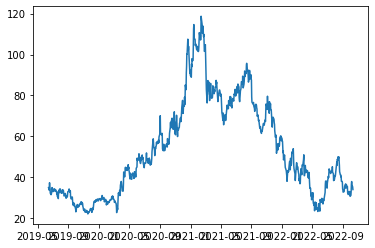

In [4]:
plt.plot(df.Adj_Close)

In [6]:
# separate target and features

y = df['Adj_Close']
X = df.drop(columns=['Adj_Close'])

In [7]:
close_prices = df['Adj_Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
x_train

array([[[0.13318147],
        [0.11982189],
        [0.15772578],
        ...,
        [0.12292876],
        [0.1103977 ],
        [0.11712924]],

       [[0.11982189],
        [0.15772578],
        [0.13224941],
        ...,
        [0.1103977 ],
        [0.11712924],
        [0.0860605 ]],

       [[0.15772578],
        [0.13224941],
        [0.12531069],
        ...,
        [0.11712924],
        [0.0860605 ],
        [0.0844035 ]],

       ...,

       [[0.50921709],
        [0.56731569],
        [0.54504972],
        ...,
        [0.22328085],
        [0.2812759 ],
        [0.24533969]],

       [[0.56731569],
        [0.54504972],
        [0.55768437],
        ...,
        [0.2812759 ],
        [0.24533969],
        [0.25735294]],

       [[0.54504972],
        [0.55768437],
        [0.53044736],
        ...,
        [0.24533969],
        [0.25735294],
        [0.31193041]]])

In [9]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [10]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
612/612 [==============================] - 10s 12ms/step - loss: 0.0062
Epoch 2/3
612/612 [==============================] - 8s 12ms/step - loss: 0.0025
Epoch 3/3
612/612 [==============================] - 7s 12ms/step - loss: 0.0020


In [12]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

6/6 [==============================] - 1s 14ms/step


3.55080229104194

C:\Users\laura\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


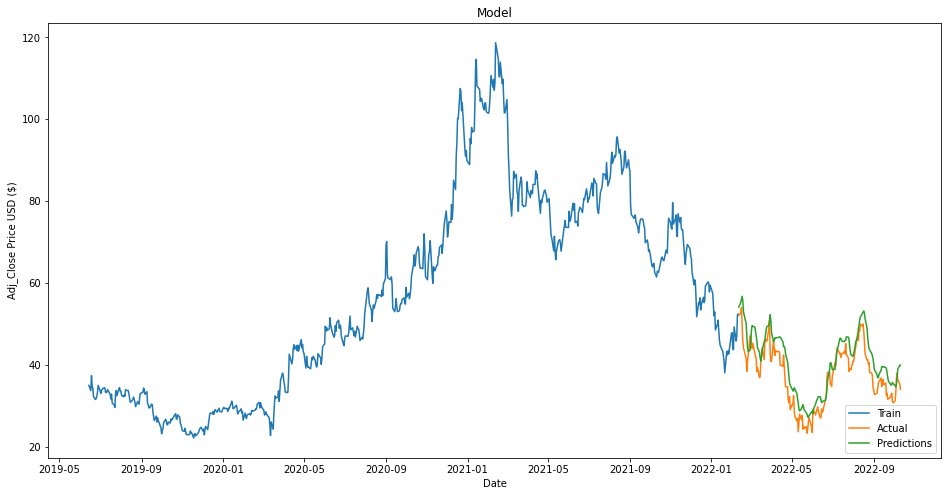

In [13]:
data = df.filter(['Adj_Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Adj_Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Adj_Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

source: https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

In [14]:
validation

Adj_Close  Predictions
Date                              
2022-02-11  52.099998    54.111618
2022-02-14  52.630001    55.300968
2022-02-15  54.000000    56.003746
2022-02-16  49.560001    56.763084
2022-02-17  45.660000    55.660458
...               ...          ...
2022-10-05  36.669998    35.104378
2022-10-06  37.939999    36.870007
2022-10-07  36.340000    38.950783
2022-10-10  35.340000    39.943851
2022-10-11  34.029999    39.893650

[167 rows x 2 columns]

In [15]:
validation.to_csv("CHWY_LSTM_model_validation_for_Tableau.csv")